In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel, euclidean_distances
from sklearn.preprocessing import StandardScaler
from scipy.sparse.linalg import eigsh
import pandas as pd
from collections import Counter

# Utility functions 

def plot_eigen(w,v):
        k = len(w)
        plt.figure(figsize=(16,6))
        plt.subplot(2, 5, 1)
        plt.plot(w, 'bo')
        plt.title('Eigenvalues')
        for i in range(k):
            plt.subplot(2, 5, i+2)
            plt.plot(v[i])
            plt.title('Eigenvector ' + str(i+1))
        plt.show()
            
def degree_matrix(G):
    D = np.zeros_like(G)
    for i, row in enumerate(G):
        D[i][i] = np.sum(row)
    return D

def is_symmetric(M):
    return np.allclose(M, M.T, atol=1e-32)

def plot_with_labels(v, labels, title=''):
    plt.figure(figsize=(10,10))
    for label in np.unique(labels):
        idx = np.where(labels == label)[0]
        plt.plot(v[idx, 0], v[idx, 1], 'o')
    plt.title(title)
    plt.show()

# Spectral Clustering
According to the paper *A Tutorial on Spectral Clustering* by Ulrike von Luxburg, the baseline spectral clustering algorithm is composed of three main steps:
1. Defining a similarity measure between nodes, and constructing the related similarity matrix.
2. From the similarity matrix, costructing a (possibly weighted) graph, here represented as adjacency matrix.
3. Computing the graph Laplacian and its first (as in smallest) eigenvectors and eigenvalues.

Once we have the eigenvalues, we sort them in ascending order and cluster the first corresponding eigenvectors using k-means. We do this because graph laplacians enhance clustering properties of the data, making it easier for k-means to detect clusters.

# Part 1 - Similarity

## Similarity Matrix
Defined by the Euclidean distance. Since we are interested in a similarity measure, we transform the distance into affinity

In [2]:
def sim_eucl(x, delta=25, plot=False):
    W = euclidean_distances(x, squared=True)

    # transform from distance to affinity        
    W = np.exp(- W ** 2 / (2. * delta ** 2))
    if plot:
        plt.title('Euclidean similarity')
        plt.imshow(W)
        plt.colorbar()
        plt.show()
    return W

## Similarity Matrix
Defined by the Gaussian similarity function

In [3]:
def sim_gaussian(x, sigma=50, plot=False):
    W = rbf_kernel(x, gamma=sigma**-2)
    if plot:
        plt.title('Gaussian similarity')
        plt.imshow(W)
        plt.colorbar()
        plt.show()
    return W

# Part 2 - Graph

## Epsilon Graph
Each node is connected to those whose similarity is greater than a threshold. Since their similarity is at most 1-&epsilon;, we can consider all edges to have the same weight

In [4]:
def eps_graph(W, unit_weight=False, eps = 0.45, plot=False):
    threshold = 1-eps
    W[W < threshold] = 0
    if unit_weight:
        W[W >= threshold] = 1
    if plot:
        plt.title(r'epsilon graph, $\epsilon={}$'.format(eps))
        plt.imshow(W)
        plt.colorbar()
        plt.show()
    return W

## K-nearest neighbors Graph
Each node is connected to the k nodes it's most similar with, and to the nodes that have it among their k-most similar

In [5]:
def knn_graph(W, k=10, plot=False):
    # sort the neighbors of a node by similarity
    argsort = np.argsort(-W, axis=1)

    for row, arow in zip(W,argsort):
        # for each row, keep the k most similar (not counting the node itself)
        # by setting the others to zero
        row[arow[k+1:]] = 0

    # make the graph symmetric
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i,j] = max(W[i,j],W[j,i])
    if plot:
        plt.title('{} Nearest Neighbors'.format(k))
        plt.imshow(W)
        plt.colorbar()
        plt.show()
    return W

## Mutual K-nearest neighbors Graph
Each node is connected to the k nodes it's most similar with, if those nodes have it among their k-most similar too

In [6]:
def mknn_graph(W, k=10, plot=False):
    # sort the neighbors of a node by similarity
    argsort = np.argsort(-W, axis=1)

    for row, arow in zip(W,argsort):
        # for each row, keep the k most similar (not counting the node itself)
        # by setting the others to zero
        row[arow[k+1:]] = 0

    # connect nodes only if there are connections both ways
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W[i,j] = min(W[i,j],W[j,i])
    if plot:
        plt.title('{} Mutual Nearest Neighbors'.format(k))
        plt.imshow(W)
        plt.colorbar()
        plt.show()
    return W

## Fully Connected Graph
if the similarity measure itself already encodes the concept of local neighborhood, we can use it as-is as weighted adjacency matrix

In [7]:
def full_graph(W, plot=False):
    if plot:
        plt.title('Fully connected graph, keep as is')
        plt.imshow(W)
        plt.colorbar()
        plt.show()
    return W

# Part 3 - Graph Laplacian and Clustering

## Unnormalized spectral clustering

In [8]:
def unnorm_sc(G, k=5, plot=False):
    
    D = degree_matrix(G)
    
    # Unnormalized Laplacian, defined by Degree Matrix minus Adjacency Matrix
    L = np.subtract(D, G)
    
    if plot:
        plt.title('Unnormalized Laplacian')
        plt.imshow(L)
        plt.colorbar()
        plt.show()

    # Compute the first k eigenvectors v_1, ... , v_k of L.
    w,v = np.linalg.eigh(L)
    if plot:
        plot_eigen(w[:k],v[:,:k])

    # F or i = 1, . . . , n, let yi ∈ R^k be the vector corresponding to the i-th row of U        
    # Cluster the points (y_i)_i=1,...,n with the k-means algorithm into clusters C1, ... , Ck.

    kmeans = KMeans(n_clusters=k).fit(v[:,:k])

    if plot:
        pca = PCA(n_components=2)
        v_new = pca.fit_transform(v[:,:k])
        plt.scatter(v_new[:,0], v_new[:,1], c=kmeans.labels_)
        plt.show()
    return kmeans.labels_

## Normalized spectral clustering according to Shi and Malik (2000)

In [9]:
def shi_malik_sc(G, k=5, plot=False):

    D = degree_matrix(G)

    # Normalized Laplacian, defined by
    # Lrw := D^−1 L = I − D^−1 W
    
    D_temp = np.linalg.inv(D)

    L = np.subtract(np.eye(D.shape[0]), D_temp.dot(G))

    # Compute the first k eigenvectors v_1, ... , v_k of L_.
    if plot:
        plt.title('Random Walk Laplacian')
        plt.imshow(L)
        plt.colorbar()
        plt.show()

    #w,v = eigsh(L, 7, which='SA', v0=np.ones(len(L)))
    #plot_eigen(w,v)

    w,v = np.linalg.eigh(L)
    if plot:
        plot_eigen(w[:k],v[:,:k])

    # F or i = 1, . . . , n, let yi ∈ R^k be the vector corresponding to the i-th row of U        
    # Cluster the points (y_i)_i=1,...,n with the k-means algorithm into clusters C1, ... , Ck.

    kmeans = KMeans(n_clusters=k).fit(v[:,:k])
    if plot:
        pca = PCA(n_components=2)
        v_new = pca.fit_transform(v[:,:k])
        plt.scatter(v_new[:,0], v_new[:,1], c=kmeans.labels_)
        plt.show()
    return kmeans.labels_


## Normalized spectral clustering according to Ng, Jordan, and Weiss (2002)

In [10]:

def ng_jordan_weiss_sc(G, k=5, plot=False):

    # Compute the normalized Laplacian L_sym, defined as
    # L_sym := D^−1/2 L D^−1/2 = I − D^−1/2 W D^−1/2
    D = degree_matrix(G)
    D_temp = np.linalg.inv(D)**0.5
    
    L = np.subtract(np.eye(len(D)), (D_temp.dot(G).dot(D_temp)))

    if plot:
        plt.title('Symmetric Laplacian')
        plt.imshow(L)
        plt.colorbar()
        plt.show()

    # Compute the first k eigenvectors v_1, ... , v_k of L_sym.

    w,v = np.linalg.eigh(L)
    if plot:
        plot_eigen(w[:k],v[:,:k])

    # Form the matrix U ∈ R^n×k from V by normalizing the row sums to have norm 1, that is u_ij = v_ij / (Sigma_k v^2_ik)^1/2

    u = np.empty([len(v), k])
    for i, row in enumerate(v):
        rowsum = 0
        for item in row[:k]:
            rowsum += item*item
        rowsum = np.sqrt(rowsum)
        for j, item in enumerate(row[:k]):
            u[i,j] = item / rowsum  

    # F or i = 1, . . . , n, let yi ∈ R^k be the vector corresponding to the i-th row of U        
    # Cluster the points (y_i)_i=1,...,n with the k-means algorithm into clusters C1, ... , Ck.

    kmeans = KMeans(n_clusters=k).fit(u)
    if plot:
        pca = PCA(n_components=2)
        u_new = pca.fit_transform(u)
        plt.scatter(u_new[:,0], u_new[:,1], c=kmeans.labels_)
        plt.show()
        
    return kmeans.labels_

In [11]:
def spectral_clustering(x, sim='gaussian', sim_param=25, graph='mknn', graph_param=20, method='ng_jordan_weiss', k=5, plot=False):
    if sim == 'euclidean':
        W = sim_eucl(x, delta=sim_param, plot=plot)
    elif sim == 'gaussian':
        W = sim_gaussian(x, sigma=sim_param, plot=plot)
    elif sim == 'cosine':
        W = sim_cosine(x, plot=plot)
    else:
        raise Exception('Unknown similarity')
    if graph == 'eps':
        G = eps_graph(W, eps=graph_param, plot=plot)
    elif graph == 'knn':
        G = knn_graph(W, k=graph_param, plot=plot)
    elif graph == 'mknn':
        G = mknn_graph(W, k=graph_param, plot=plot)
    elif graph == 'full':
        G = full_graph(W, plot=plot)
    else:
        raise Exception('Unknown graph')
    if method == 'unnorm':
        return unnorm_sc(G, k=k, plot=plot)
    elif method == 'shi_malik':
        return shi_malik_sc(G, k=k, plot=plot)
    elif method == 'ng_jordan_weiss':
        return ng_jordan_weiss_sc(G, k=k, plot=plot)
    else:
        raise Exception('Unknown method')

# Real Data

In [12]:
props = np.load('props.npy')
labels = np.load('labels.npy')
df = pd.DataFrame(np.load('matrix.npy'),columns=props, index=labels)

y = []
to_drop = []
# counting how many malwares belong to the 4 main categories, and dropping the others
labelsCounter = { 'APT1': [], 'Crypto': [], 'Locker': [], 'Zeus': [] }
for i,item in enumerate(labels):
    if 'APT1' in item:
        y.append(1)
        labelsCounter['APT1'].append(i)
    elif 'Crypto' in item:
        y.append(2)
        labelsCounter['Crypto'].append(i)
    elif 'Locker' in item:
        y.append(3)
        labelsCounter['Locker'].append(i)
    elif 'Zeus' in item:
        y.append(4)
        labelsCounter['Zeus'].append(i)
    else:
        to_drop.append(i)

y = np.array(y)
mask = np.ones(df.shape[0], dtype=bool)
mask[to_drop] = False
df = df[mask]
x_real = df.values
x_real = StandardScaler().fit_transform(x_real)
y_real = y
df.head()

,file_access,pe_sec_entropy,pe_imports,reg_access,sig_antimalware_metascan,reg_write,reg_read,sig_modify_proxy,sig_clamav,sig_antivirus_virustotal,...,sig_antivm_vpc_files,sig_antiemu_wine_func,sig_antivm_vmware_keys,sig_ransomware_message,sig_cryptam,sig_creates_nullvalue,sig_ransomware_radamant,sig_mimics_icon,sig_ransomware_recyclebin,sig_disables_windowsupdate
APT1,12.0,3.0,102.0,546.0,0.0,8.0,300.0,0.0,1.0,49.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APT1,12.0,4.0,103.0,548.0,0.0,8.0,302.0,0.0,1.0,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APT1,0.0,2.0,69.0,0.0,0.0,0.0,0.0,0.0,1.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APT1,12.0,4.0,79.0,40.0,0.0,2.0,18.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APT1,24.0,3.0,82.0,40.0,0.0,8.0,14.0,0.0,0.0,47.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


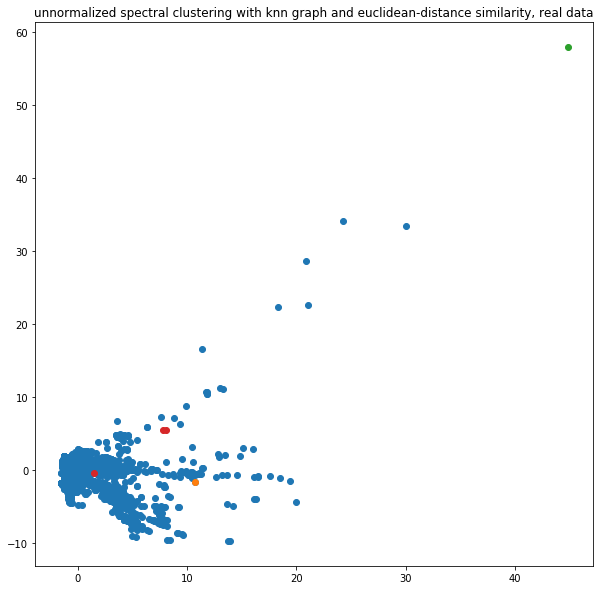

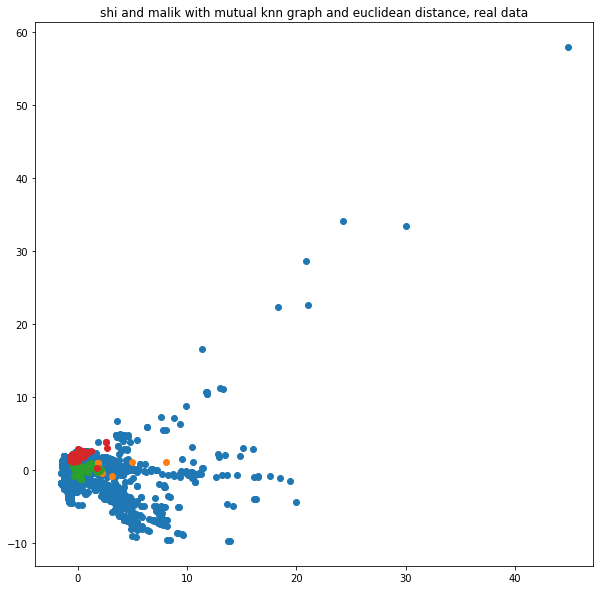

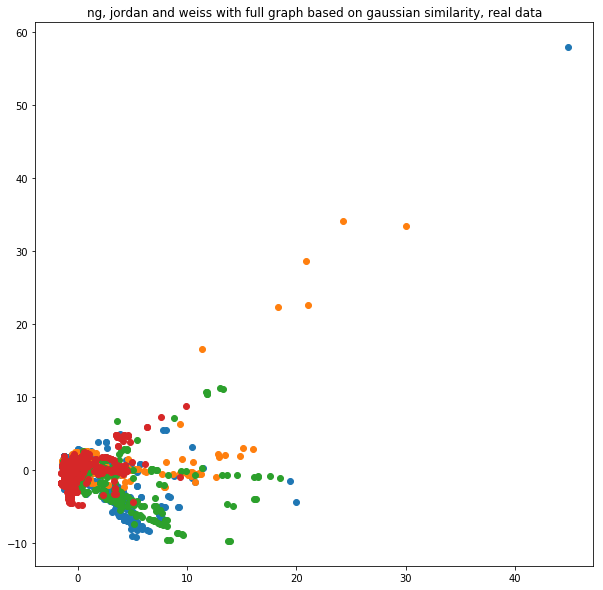

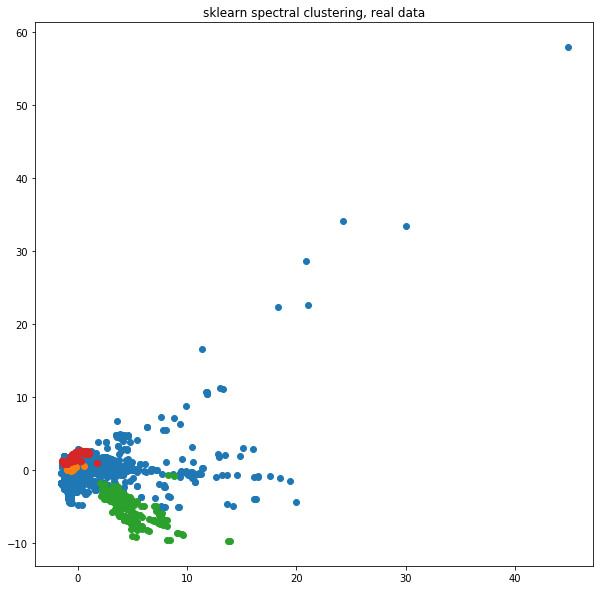

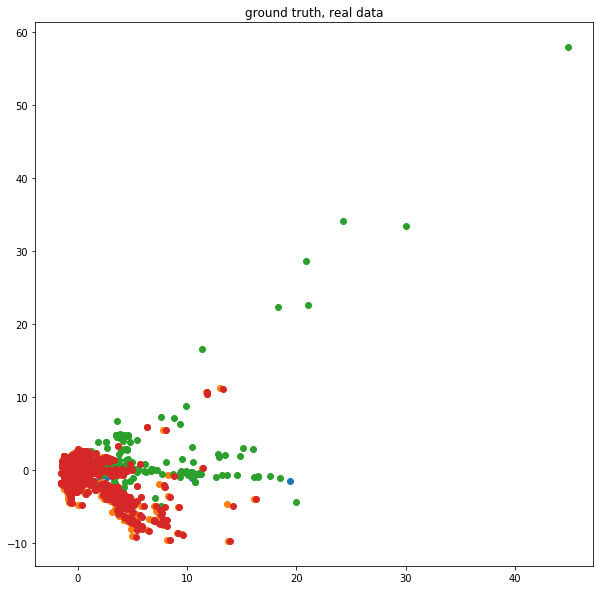

In [13]:
x = x_real
y = y_real
k = 4
data = 'real'
y1 = spectral_clustering(x, sim='euclidean', sim_param=500, graph='knn', graph_param=25, method='unnorm', k=k, plot=False)
y2 = spectral_clustering(x, sim='euclidean', sim_param=100, graph='mknn', graph_param=75, method='shi_malik', k=k, plot=False)
y3 = spectral_clustering(x, sim='gaussian', sim_param=10, graph='knn', graph_param=10, method='ng_jordan_weiss', k=k, plot=False)
y4 = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', n_neighbors=150).fit_predict(x)

pca = PCA(n_components=2)
x_reduced = pca.fit_transform(x)
plot_with_labels(x_reduced, y1, title='unnormalized spectral clustering with knn graph and euclidean-distance similarity, {} data'.format(data))
plot_with_labels(x_reduced, y2, title='shi and malik with mutual knn graph and euclidean distance, {} data'.format(data))
plot_with_labels(x_reduced, y3, title='ng, jordan and weiss with full graph based on gaussian similarity, {} data'.format(data))
plot_with_labels(x_reduced, y4, title='sklearn spectral clustering, {} data'.format(data))
plot_with_labels(x_reduced, y, title='ground truth, {} data'.format(data))

# Synthetic data

In [14]:
n_samples = 1500

x_synth1, y_synth1 = make_circles(n_samples=n_samples, factor=.4,  noise=.05)
x_synth2, y_synth2 = make_circles(n_samples=n_samples, factor=.1, noise=.05)
x_synth1 = x_synth1*8
x_synth2 = x_synth2*1
y_synth1 = y_synth1+2
x_synth = np.vstack([x_synth1, x_synth2])
y_synth = np.hstack([y_synth1, y_synth2])

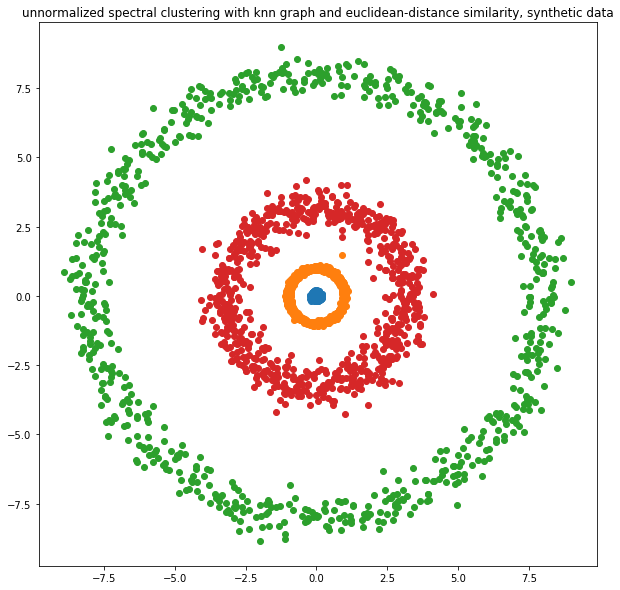

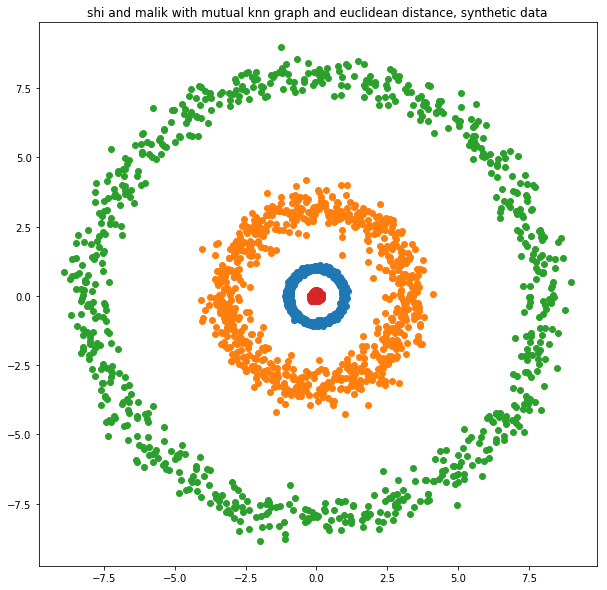

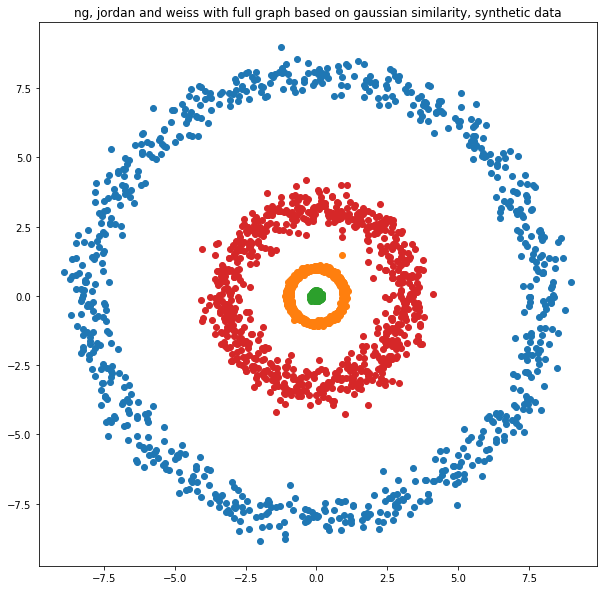

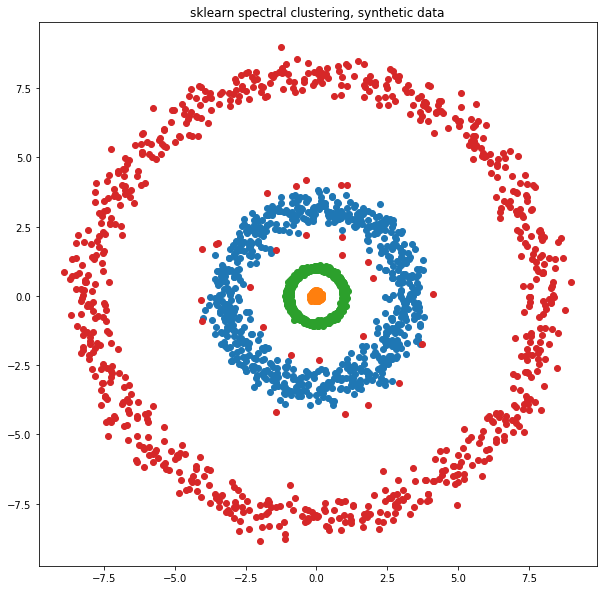

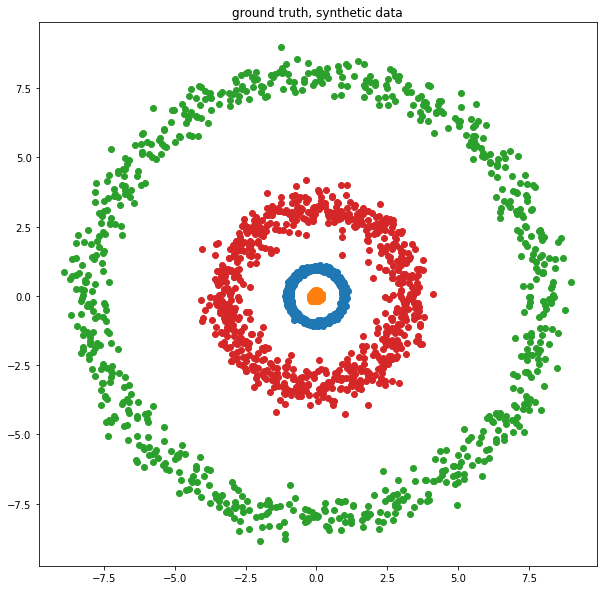

In [16]:
x = x_synth
y = y_synth
k = 4
data = 'synthetic'
y1 = spectral_clustering(x, sim='euclidean', sim_param=500, graph='knn', graph_param=25, method='unnorm', k=k, plot=False)
y2 = spectral_clustering(x, sim='euclidean', sim_param=100, graph='mknn', graph_param=75, method='shi_malik', k=k, plot=False)
y3 = spectral_clustering(x, sim='gaussian', sim_param=10, graph='knn', graph_param=10, method='ng_jordan_weiss', k=k, plot=False)
y4 = SpectralClustering(n_clusters=k, gamma=3).fit_predict(x)

plot_with_labels(x, y1, title='unnormalized spectral clustering with knn graph and euclidean-distance similarity, {} data'.format(data))
plot_with_labels(x, y2, title='shi and malik with mutual knn graph and euclidean distance, {} data'.format(data))
plot_with_labels(x, y3, title='ng, jordan and weiss with full graph based on gaussian similarity, {} data'.format(data))
plot_with_labels(x, y4, title='sklearn spectral clustering, {} data'.format(data))
plot_with_labels(x, y, title='ground truth, {} data'.format(data))